#Style Transfer

The idea of the style transfer is to take two images, and the idea is to produce an image with the same content as the first image and with the Style of the Secound 

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import PIL

import numpy as np

from scipy.misc import imread
#from collections import namedtuple
import matplotlib.pyplot as plt

%matplotlib inline

Implemting some functions to deal with images 

In [0]:
# the mean and std to normalize the images 
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)


# preprocess the image by scaling and normalizing it 
def preprocess(img, size=512):
    transform = T.Compose([
        T.Scale(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

# prepare the image to display it
def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

# Function that take the Path of the image and process it and return it's features.
def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = Variable(img.type(dtype))
    return extract_features(img_var, cnn), img_var

Use a pre tranined network to extract the features for the image, we will use Squeeznet beacause of it's  small size and  efficiency. 

In [0]:
# define the types of variables to run on GPU
dtype = torch.cuda.FloatTensor 

# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

# a function that take a image and return the fatures of the image extracted by the network
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Variable of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Variable of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    # enumerate over each leyar separately
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

# Content Loss 

We use only one Layer to represent the content of the image 

In [0]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    Loss = content_weight * ((content_current - content_original).pow(2)).sum()
    
    return Loss


# Gram Matrix

We use the gram matrix to reprsent the style of the image, it's calculate the propaplety of the filters to appear together, it's the same as covariance matrix, but it's more efficient to compute 

In [0]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Variable of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Variable of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """
    N, C, H, W = features.shape
    features_reshape = features.view(N*C, H*W)
    gram = features_reshape.mm(features_reshape.t())
    gram = gram.view(N, C, C)
    if normalize :
        gram /= (H*W*C)
        
    return gram


# Style loss

We use the gram matrix of the features a representation to the image style, we use some layers to represent the style 

In [0]:
# Now put it together in the style_loss function...
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Variable giving the Gram matrix the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A PyTorch Variable holding a scalar giving the style loss.
    """
    
    loss = Variable(torch.FloatTensor([0])).type(dtype)
    for i in range(len(style_layers)):
        gram_style = gram_matrix(feats[style_layers[i]]) # compute gram matrix for layer choosed 
        gram_target = style_targets[i]
        loss += style_weights[i] * (gram_style - gram_target).pow(2).sum()
        
    return loss

#Total-variation Regularization 

We use it as a regularizer to make the generated image smoother, it's try to minimize the diffrance between the consecutive Pixels

In [0]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    
    # you minimize the diffrance between the neighboring pixels so that the image will be smoother 
    Hight = (img[:,:, 1:,:] - img[:, :, :-1, :]).pow(2).sum()  # by distributing summation 
    Width = (img[:,:, :, 1:] - img[:, :, :, :-1]).pow(2).sum()
    loss = tv_weight * (Hight + Width).sum()
    
    return loss


# Style Transfer 

we constuct the function to try to generate an image with the content of an image and styke of the other 

In [0]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size)
    content_img_var = Variable(content_img.type(dtype))
    feats = extract_features(content_img_var, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size)
    style_img_var = Variable(style_img.type(dtype))
    feats = extract_features(style_img_var, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img_var = Variable(img, requires_grad=True)

    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img_var Torch variable, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img_var], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img_var, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img_var, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img_var], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.cpu()))
    plt.show()
    
    #print final result  
    print('Final Result')
    f, aaxis = plt.subplots(1, 3)
    aaxis[0].axis('off')
    aaxis[1].axis('off')
    aaxis[2].axis('off')
    aaxis[0].set_title('Content Img')
    aaxis[1].set_title('Style Img')
    aaxis[2].set_title('Generated Img')
    aaxis[0].imshow(deprocess(content_img.cpu()))
    aaxis[1].imshow(deprocess(style_img.cpu()))
    aaxis[2].imshow(deprocess(img.cpu()))
    

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


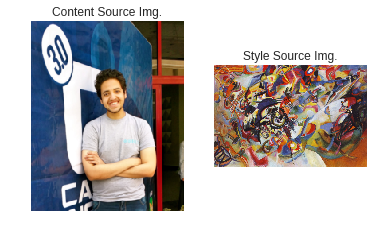

Iteration 0


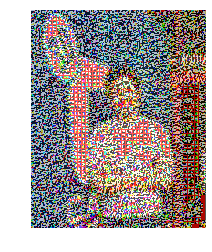

Iteration 100


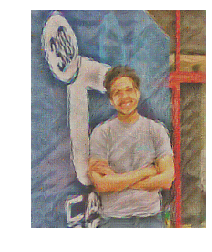

Iteration 199


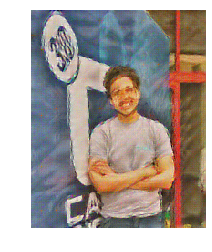

Final Result


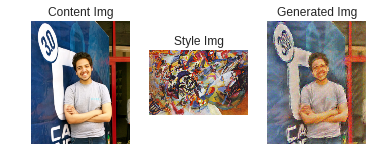

In [38]:
# Composition VII 
params1 = {
    'content_image' :'omar_S.jpg',
    'style_image' : 'composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


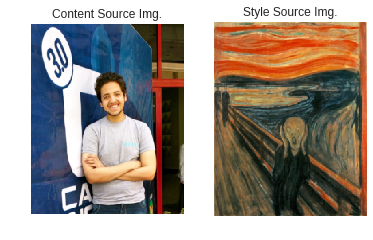

Iteration 0


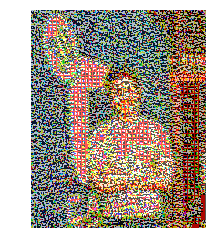

Iteration 100


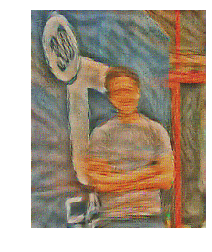

Iteration 199


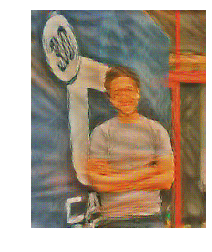

Final Result


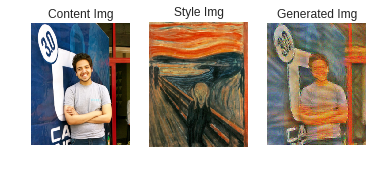

In [39]:
# Scream 
params2 = {
    'content_image':'omar_S.jpg',
    'style_image':'the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


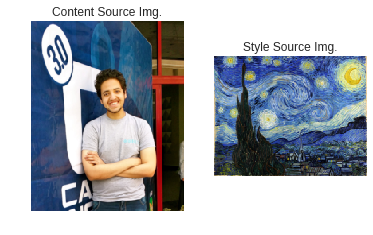

Iteration 0


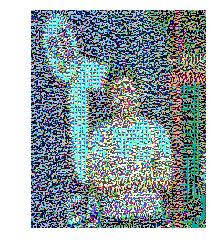

Iteration 100


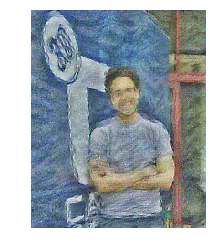

Iteration 199


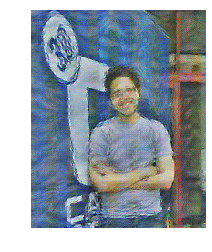

Final Result


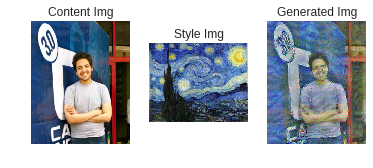

In [46]:
# Starry Night 
params3 = {
    'content_image' : 'omar_S.jpg',
    'style_image' : 'starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

#Feature Inversion

You can retrive the contnet of the image by using the same technique, But yo setting the  weights of the Style to Zero

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


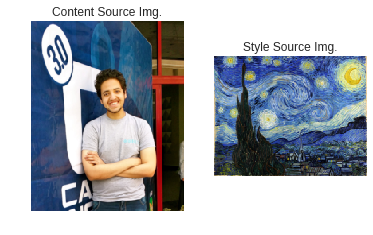

Iteration 0


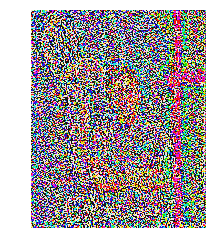

Iteration 100


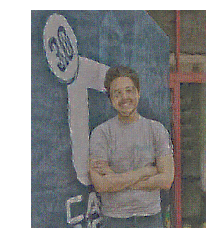

Iteration 199


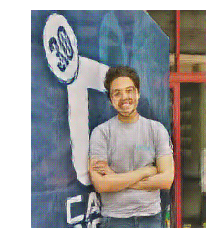

Final Result


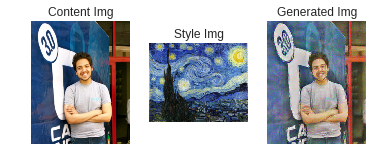

In [50]:
# Feature Inversion 
params_inv = {
    'content_image' : 'omar_S.jpg',
    'style_image' : 'starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)